1. EXPLORACIÓN INICIAL DE DATOS

In [953]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [954]:
# Carga de datos
df = pd.read_csv('../Base_de_datos.csv', sep=';', encoding='utf-8')

In [955]:
# Dimensiones y tipos iniciales
print(f"Dimensiones del dataset: {df.shape}")
df.info()

Dimensiones del dataset: (10763, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10763 entries, 0 to 10762
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tipo_credito                   10763 non-null  int64  
 1   fecha_prestamo                 10763 non-null  object 
 2   capital_prestado               10763 non-null  int64  
 3   plazo_meses                    10763 non-null  int64  
 4   edad_cliente                   10763 non-null  int64  
 5   tipo_laboral                   10763 non-null  object 
 6   salario_cliente                10763 non-null  int64  
 7   total_otros_prestamos          10763 non-null  int64  
 8   cuota_pactada                  10763 non-null  int64  
 9   puntaje                        10763 non-null  object 
 10  puntaje_datacredito            10757 non-null  float64
 11  cant_creditosvigentes          10763 non-null  int64  
 12  huella_co

- Errores de Tipo: fecha_prestamo está como object (debe ser datetime) y puntaje está como object.

- Valores Nulos: puntaje_datacredito, saldo_mora, saldo_total, saldo_principal, saldo_mora_codeudor, promedio_ingresos_datacredito y tendencia_ingresos.

- Variable Objetivo: Pago_atiempo (Dicotómica: 0 o 1).

CARACTERIZACIÓN DE LOS DATOS:

- Dicotómicas (Target): Pago_atiempo (0/1).

- Politómicas: tipo_credito (codificada numéricamente), tipo_laboral.

- Numéricas Continuas: capital_prestado, salario_cliente, cuota_pactada, puntaje, puntaje_datacredito, saldo_mora, saldo_total, saldo_principal, saldo_mora_codeudor, promedio_ingresos_datacredito.

- Numéricas Discretas: plazo_meses, edad_cliente, total_otros_prestamos, cant_creditosvigentes, huella_consulta, creditos_sectorFinanciero, creditos_sectorCooperativo, creditos_sectorReal.

- Temporales: fecha_prestamo.

In [956]:
# Definición del target

target = 'Pago_atiempo'

In [957]:
# Unificación de nulos: Convertimos cualquier representación extraña a np.nan
df.replace(['', ' ', 'NA', 'N/A', 'nan', 'null'], np.nan, inplace=True)

In [958]:
# Revisión de duplicados
duplicados = df.duplicated().sum()
print(f"Cantidad de registros duplicados: {duplicados}")

if duplicados > 0:
    df.drop_duplicates(inplace=True)
    print("Registros duplicados eliminados.")

Cantidad de registros duplicados: 0


In [959]:
# Verificación final de nulos
print("Resumen de valores nulos unificados:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Resumen de valores nulos unificados:
puntaje_datacredito                 6
saldo_mora                        156
saldo_total                       156
saldo_principal                   405
saldo_mora_codeudor               590
promedio_ingresos_datacredito    2930
tendencia_ingresos               2932
dtype: int64


Existen variables con una tasa de ausencia cercana al 30% (promedio_ingresos_datacredito y tendencia_ingresos), lo que requiere una evaluación sobre su utilidad real frente al costo de imputar tantos datos.

Variables de saldos y puntajes presentan nulos mínimos que son manejables mediante técnicas estándar de limpieza.

Antes de proceder con la eliminación definitiva de columnas, realizaremos una prueba de importancia relativa sobre saldo_mora. El objetivo es confirmar si esta variable actúa como un "delator" del resultado (Data Leakage), lo que invalidaría su uso en un simulador para clientes nuevos.

In [960]:
# --- Prueba para Feature Selection ---
# Validamos el impacto de saldo_mora antes de eliminarla
if 'saldo_mora' in df.columns:
    print("Relación entre mora previa y pago a tiempo:")
    print(pd.crosstab(df['saldo_mora'] > 0, df[target], normalize='index'))

Relación entre mora previa y pago a tiempo:
Pago_atiempo         0         1
saldo_mora                      
False         0.045854  0.954146
True          0.363636  0.636364


FEATURE SELECTION Y LIMPIEZA DE DATOS

Se ha decidido realizar una reducción de dimensionalidad eliminando variables que no aportan valor predictivo o que presentan riesgos técnicos para la estabilidad del modelo en producción:

- Eliminación por Fuga de Datos (Data Leakage): Se excluye la variable saldo_mora. La tabla cruzada revela que el 36.3% de los clientes con mora previa no pagan a tiempo, frente a solo un 4.5% de los que no tienen mora. Dado que el objetivo es anticipar el comportamiento de nuevos usuarios, el uso de saldos en mora actuales contaminaría el entrenamiento, ya que un usuario nuevo entra al sistema con saldo cero. Su inclusión generaría un modelo sobreajustado (overfitting) que fallaría al generalizar en el simulador.

- Reducción de Dimensionalidad y Missingness: Se elimina la variable tendencia_ingresos. Esta decisión se basa en: Alta tasa de valores faltantes (Missingness): Presenta casi un 30% de nulos, lo que dificulta una imputación confiable y complejidad Innecesaria: Al contar con datos duros como salario_cliente y promedio_ingresos_datacredito, la tendencia se considera una variable redundante que añade ruido estadístico.

Tratamiento de Nulos Conservados: Las variables con porcentajes bajos de nulos (como puntajes y saldos financieros) se conservan debido a su alta importancia para el negocio. Estos vacíos serán tratados mediante técnicas de imputación en el siguiente avance del pipeline.

In [961]:
# Eliminación de variables 
# saldo_mora se elimina porque indica un evento futuro al otorgamiento (Leakage)
# tendencia_ingresos se elimina por alta tasa de nulos y baja relevancia inicial
vars_to_drop = ['saldo_mora', 'tendencia_ingresos']
# Verificamos si las columnas existen antes de borrarlas para evitar errores al re-ejecutar
vars_existing = [v for v in vars_to_drop if v in df.columns]
df.drop(columns=vars_existing, inplace=True)


# --- VERIFICACIÓN DE RESULTADOS ---
print(f"Variables eliminadas: {vars_existing}")
print(f"Nueva cantidad total de columnas en el dataset: {df.shape[1]}")

Variables eliminadas: ['saldo_mora', 'tendencia_ingresos']
Nueva cantidad total de columnas en el dataset: 21


In [962]:
# --- Conversión de tipos ---
# Convertir fecha a datetime
df['fecha_prestamo'] = pd.to_datetime(df['fecha_prestamo'])

# Corregir la columna 'puntaje' (reemplazar coma por punto y convertir a float)
df['puntaje'] = df['puntaje'].astype(str).str.replace(',', '.').astype(float)

# Asegurar Continuas (Float)
# Estas variables pueden tener decimales y nulos
# Variables Continuas (Deben ser Float64 porque representan dinero/puntaje con precisión)
cols_continuas = ['capital_prestado', 'salario_cliente', 'cuota_pactada', 
                  'puntaje_datacredito', 'saldo_total', 'saldo_principal', 
                  'saldo_mora_codeudor', 'promedio_ingresos_datacredito', 'puntaje']

for col in cols_continuas:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')

# Asegurar Discretas (Int64)
# El tipo 'Int64' (con I mayúscula) permite números enteros y valores nulos (NaN)
cols_discretas = ['plazo_meses', 'edad_cliente', 'total_otros_prestamos', 
                  'cant_creditosvigentes', 'huella_consulta', 'creditos_sectorFinanciero', 
                  'creditos_sectorCooperativo', 'creditos_sectorReal']

for col in cols_discretas:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')


# CONVERSIÓN A CATEGÓRICAS

# Definimos las variables que son grupos o etiquetas
# Incluimos tipo_credito (que es un código) y el target
cols_categoricas = ['tipo_laboral', 'tipo_credito', 'Pago_atiempo']

for col in cols_categoricas:
    df[col] = df[col].astype('category')

# Verificación de corrección
print("--- Estructura final del Dataset ---")
df.info()

--- Estructura final del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10763 entries, 0 to 10762
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   tipo_credito                   10763 non-null  category      
 1   fecha_prestamo                 10763 non-null  datetime64[ns]
 2   capital_prestado               10763 non-null  float64       
 3   plazo_meses                    10763 non-null  Int64         
 4   edad_cliente                   10763 non-null  Int64         
 5   tipo_laboral                   10763 non-null  category      
 6   salario_cliente                10763 non-null  float64       
 7   total_otros_prestamos          10763 non-null  Int64         
 8   cuota_pactada                  10763 non-null  float64       
 9   puntaje                        10763 non-null  float64       
 10  puntaje_datacredito            10757 non-null

In [963]:
# Definición del target
target = 'Pago_atiempo'

# Seleccionamos numéricas: Incluye float64, int64 e Int64 (los que tienen nulos)
cols_num = df.select_dtypes(include=['number']).columns.tolist()

# Seleccionamos categóricas: Buscamos específicamente el tipo 'category'
cols_cat = df.select_dtypes(include=['category']).columns.tolist()

# Variables Temporales: Detecta datetime64
cols_date = df.select_dtypes(include=['datetime64']).columns.tolist()

# Limpieza de listas: Eliminamos el target de donde aparezca para evitar sesgo
if target in cols_num:
    cols_num.remove(target)
if target in cols_cat:
    cols_cat.remove(target)

print(f"Predictores Numéricos ({len(cols_num)}): {cols_num}")
print(f"Predictores Categóricos ({len(cols_cat)}): {cols_cat}")
print(f"Variable Objetivo: {target}")

Predictores Numéricos (17): ['capital_prestado', 'plazo_meses', 'edad_cliente', 'salario_cliente', 'total_otros_prestamos', 'cuota_pactada', 'puntaje', 'puntaje_datacredito', 'cant_creditosvigentes', 'huella_consulta', 'saldo_total', 'saldo_principal', 'saldo_mora_codeudor', 'creditos_sectorFinanciero', 'creditos_sectorCooperativo', 'creditos_sectorReal', 'promedio_ingresos_datacredito']
Predictores Categóricos (2): ['tipo_credito', 'tipo_laboral']
Variable Objetivo: Pago_atiempo


2. EXPLORACIÓN DE DATOS Y DESCRIPCIÓN (EDA)

In [964]:
# ANÁLISIS UNIVARIABLE

# 2.1 Descripción Estadística (Variables Numéricas)
print("\n--- DESCRIPCIÓN ESTADÍSTICA COMPLETA ---")
stats_univariado = df[cols_num].describe().T

# Métricas de Dispersión y Forma 
stats_univariado['range'] = stats_univariado['max'] - stats_univariado['min']
stats_univariado['iqr'] = stats_univariado['75%'] - stats_univariado['25%']
stats_univariado['variance'] = df[cols_num].var()
stats_univariado['skewness'] = df[cols_num].skew()
stats_univariado['kurtosis'] = df[cols_num].kurt()

display(stats_univariado[['count', 'mean', '50%', 'std', 'min', 'max', 'range', 'iqr', 'skewness', 'kurtosis']])


--- DESCRIPCIÓN ESTADÍSTICA COMPLETA ---


,count,mean,50%,std,min,max,range,iqr,skewness,kurtosis
capital_prestado,10763.0,2434314.99712,1921920.0,1909642.757024,360000.0,41444153.0,41084153.0,1860009.0,3.723884,35.318093
plazo_meses,10763.0,10.575583,10.0,6.632082,2.0,90.0,88.0,6.0,2.459691,7.780121
edad_cliente,10763.0,43.94862,42.0,15.060877,19.0,123.0,104.0,20.0,1.934399,7.868936
salario_cliente,10763.0,17216431.459909,3000000.0,355476717.603482,0.0,22000000000.0,22000000000.0,2875808.0,43.776664,2211.23012
total_otros_prestamos,10763.0,6238869.648518,1000000.0,118418316.941069,0.0,6787675263.0,6787675263.0,1500000.0,38.463886,1719.280871
cuota_pactada,10763.0,243617.406671,182863.0,210493.694608,23944.0,3816752.0,3792808.0,166792.0,3.793301,26.650757
puntaje,10763.0,91.170036,95.227787,16.465441,-38.00999,95.227787,133.237777,0.0,-4.865607,24.081011
puntaje_datacredito,10757.0,780.790834,791.0,104.878031,-7.0,999.0,1006.0,68.0,-5.644513,39.437798
cant_creditosvigentes,10763.0,5.726749,5.0,3.977162,0.0,62.0,62.0,5.0,1.797738,8.623346
huella_consulta,10763.0,4.228561,4.0,3.064683,0.0,29.0,29.0,4.0,1.487102,3.998984


1. Detección de Valores Atípicos (Outliers)

- Edad: El valor máximo es 123 años. El 75% de las edades están por debajo de los 53 años, lo que hace que el dato de 123 años sea estadísticamente imposible en este contexto.

- Salario: El máximo es 22,000,000,000 (22 mil millones). Es un outlier masivo que va a "aplastar" los histogramas. (Kurtosis: 2211),  Esto confirma que los datos tienen "colas pesadas" y errores de registro (como el salario de 22 mil millones).

- Capital Prestado: El máximo es 414 millones, mientras que el 75% de la gente pide 3 millones. Hay una disparidad.

2. Variables de "Saldo 0"
saldo_mora_codeudor: Más del 75% de los datos para esta variable son ceros. Es una variable con alta concentración en el valor cero (casi todos están en el mismo estado). Aunque tiene poca varianza en la mayoría, su Kurtosis extrema (9279) indica que los pocos valores que no son cero son extremadamente altos, lo cual es típico de variables de morosidad (pocos deben, pero los que deben, deben mucho).

3. Error de Medición en puntaje
puntaje (Min: -38) y puntaje_datacredito (Min: -7). Un score crediticio no puede ser negativo. Estos registros son ruidos de sistema que deben ser saneados.

4. Asimetría Positiva (Skewness > 0):
Casi todas las variables financieras (capital_prestado, salario_cliente, saldos) tienen una asimetría positiva muy alta.
La asimetría positiva sugiere que la media está muy por encima de la mediana, lo cual es un indicador clásico de que unos pocos clientes con montos muy altos están "jalando" el promedio.


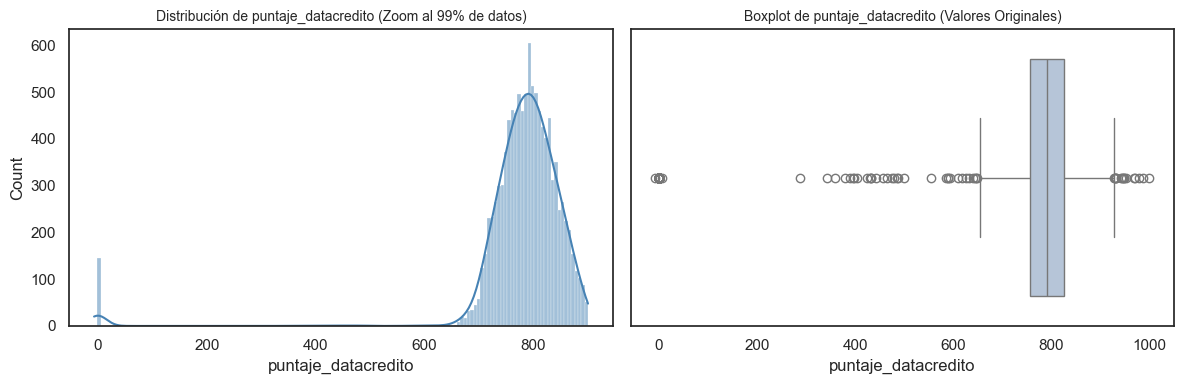

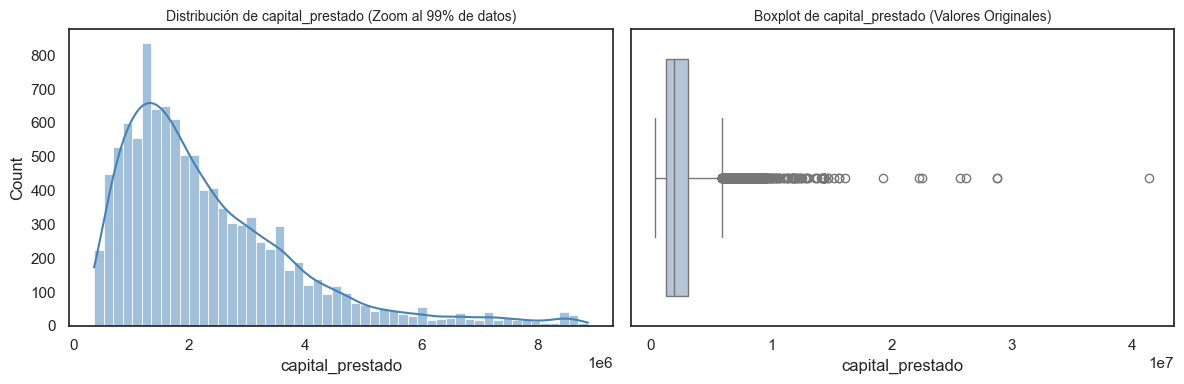

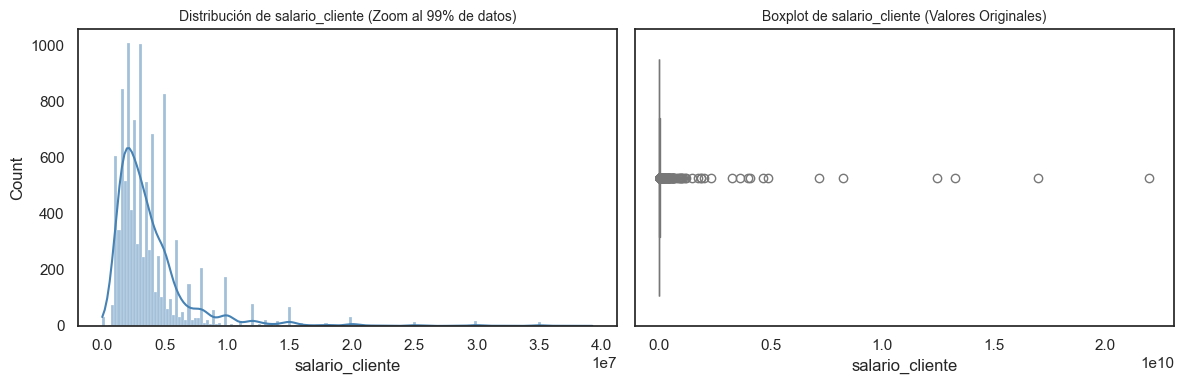

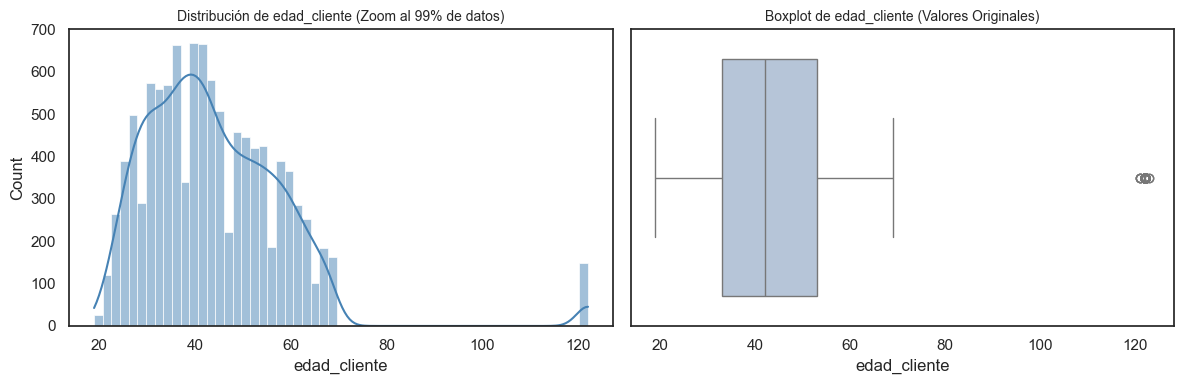

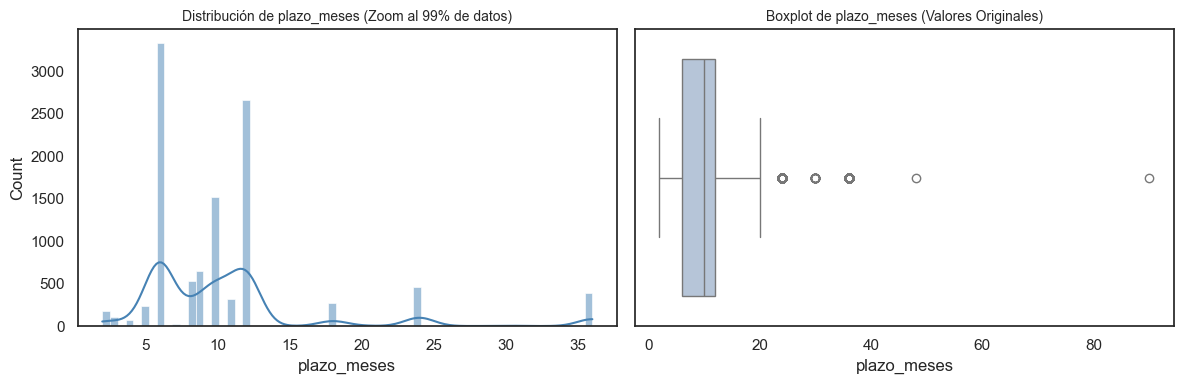

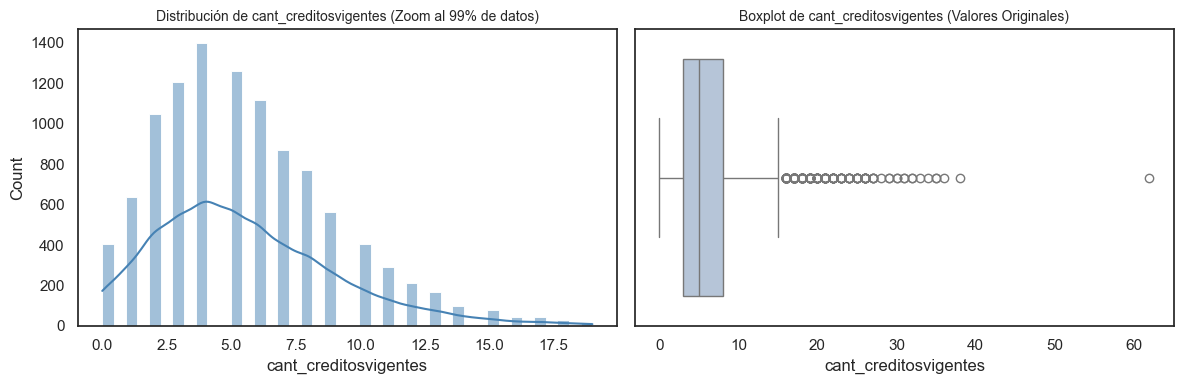

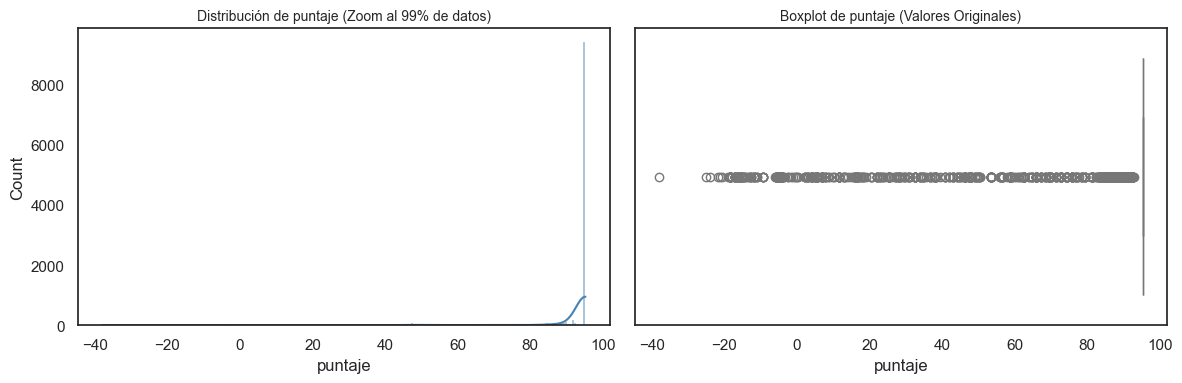


--- Frecuencias: tipo_credito ---


,Conteo,Porcentaje (%)
tipo_credito,,
4,7747,71.98
9,2876,26.72
10,116,1.08
6,21,0.20
7,2,0.02
68,1,0.01


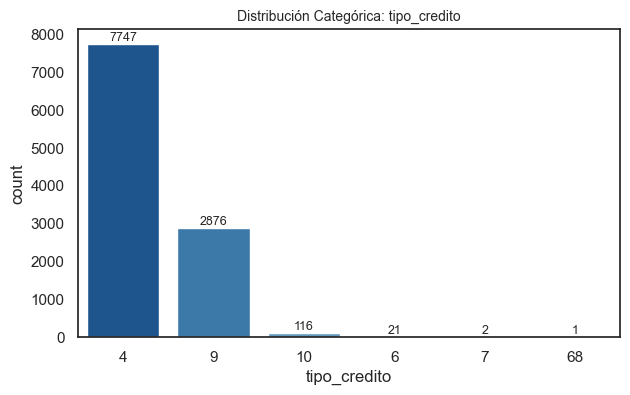


--- Frecuencias: tipo_laboral ---


,Conteo,Porcentaje (%)
tipo_laboral,,
Empleado,6754,62.75
Independiente,4009,37.25


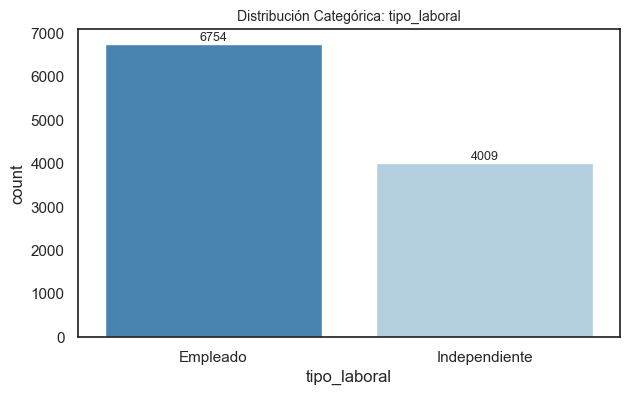


--- Frecuencias: Pago_atiempo ---


,Conteo,Porcentaje (%)
Pago_atiempo,,
1,10252,95.25
0,511,4.75


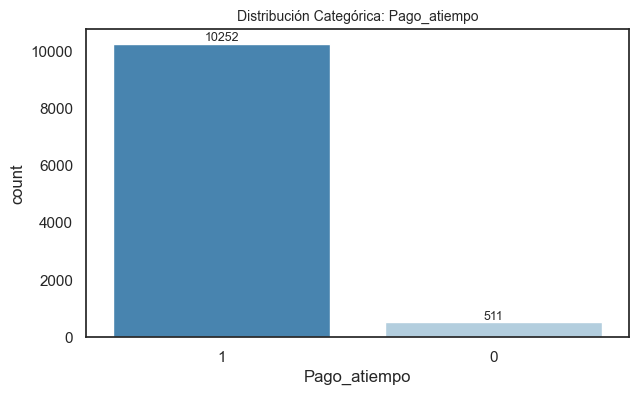


--- TABLA PIVOTE: Perfil por Tipo Laboral ---


,capital_prestado,plazo_meses,puntaje,salario_cliente
tipo_laboral,,,,
Empleado,1951365.0,10.0,95.23,2700000.0
Independiente,1872000.0,8.0,95.23,3800000.0


In [965]:
# ------------------------------------------------------------------------------
# 2.2 Visualización de Variables Numéricas Críticas
# ------------------------------------------------------------------------------
# Añadimos plazo y cantidad de créditos vigentes por su valor predictivo
vars_visual = ['puntaje_datacredito','capital_prestado', 'salario_cliente', 'edad_cliente', 
               'plazo_meses', 'cant_creditosvigentes', 'puntaje', ]

for var in vars_visual:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # DINÁMICO: Filtro de percentil 99 para evitar que outliers "aplasten" el histograma
    limite_visual = df[var].quantile(0.99)
    df_plot = df[df[var] <= limite_visual]
    
    # Histograma (Distribución y Densidad)
    sns.histplot(df_plot[var].dropna(), kde=True, color='#4682B4', ax=axes[0])
    axes[0].set_title(f'Distribución de {var} (Zoom al 99% de datos)', fontsize=10)
    
    # Boxplot (Detección visual de Outliers originales)
    sns.boxplot(x=df[var].dropna(), color='#B0C4DE', ax=axes[1])
    axes[1].set_title(f'Boxplot de {var} (Valores Originales)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 2.3 Análisis de Variables Categóricas y Target
# ------------------------------------------------------------------------------
for var in cols_cat + [target]:
    print(f"\n--- Frecuencias: {var} ---")
    conteo = df[var].value_counts()
    porcentaje = df[var].value_counts(normalize=True) * 100
    display(pd.DataFrame({'Conteo': conteo, 'Porcentaje (%)': porcentaje.round(2)}))
    
    plt.figure(figsize=(7, 4))
    ax = sns.countplot(x=var, data=df, palette='Blues_r', order=conteo.index)
    plt.title(f'Distribución Categórica: {var}', fontsize=10)
    
    # Etiquetas de datos automáticas
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=9)
    plt.show()

# ------------------------------------------------------------------------------
# 2.4 Tabla Pivote: Caracterización Inicial
# ------------------------------------------------------------------------------
print("\n--- TABLA PIVOTE: Perfil por Tipo Laboral ---")
pivot_resumen = df.pivot_table(
    index='tipo_laboral',
    values=['salario_cliente', 'puntaje', 'capital_prestado', 'plazo_meses'],
    aggfunc='median' # Usamos mediana por ser más robusta ante los outliers detectados
).round(2)

display(pivot_resumen)

1. Calidad de los Datos y Outliers
Edad del Cliente: La distribución es mayoritariamente bimodal, con picos cerca de los 30 y 45 años. Sin embargo, el Boxplot confirma valores erráticos de 123 años, que son físicamente imposibles para este contexto crediticio.

Puntaje (Score): El gráfico muestra una concentración extrema en el límite superior (95.22). Los valores negativos detectados en el análisis estadístico (-38) actúan como ruido que "estira" el Boxplot hacia la izquierda, confirmando registros que deben ser saneados.

Salario Cliente: Al aplicar el zoom al 99%, observamos una asimetría positiva (Skewness: 43.7). La masa principal de clientes gana entre 1 y 5 millones, pero la presencia del valor de 22 mil millones distorsiona cualquier cálculo de promedio, obligándonos a usar la mediana como medida de tendencia central más fiable.

2. Estructura de la Cartera (Variables Categóricas)
Tipo Laboral: Existe una clara predominancia de Empleados (6,754) sobre Independientes (4,009). Esta variable será crucial para ver si la estabilidad laboral influye en el comportamiento de pago.

Tipo de Crédito: El código "4" domina la muestra con más del 71% de los registros, lo que indica que el análisis bivariable estará sesgado hacia este producto específico.

3. Comportamiento del Target (Pago_atiempo)
Desbalanceo Crítico: El gráfico de barras revela una disparidad masiva: 10,252 clientes al día (95.25%) vs. 511 en mora (4.75%).

Implicación: El modelo de IA tendrá dificultades para "aprender" a identificar a los morosos debido a su baja representatividad. Necesitaremos estrategias de balanceo de datos en la fase de preprocesamiento.

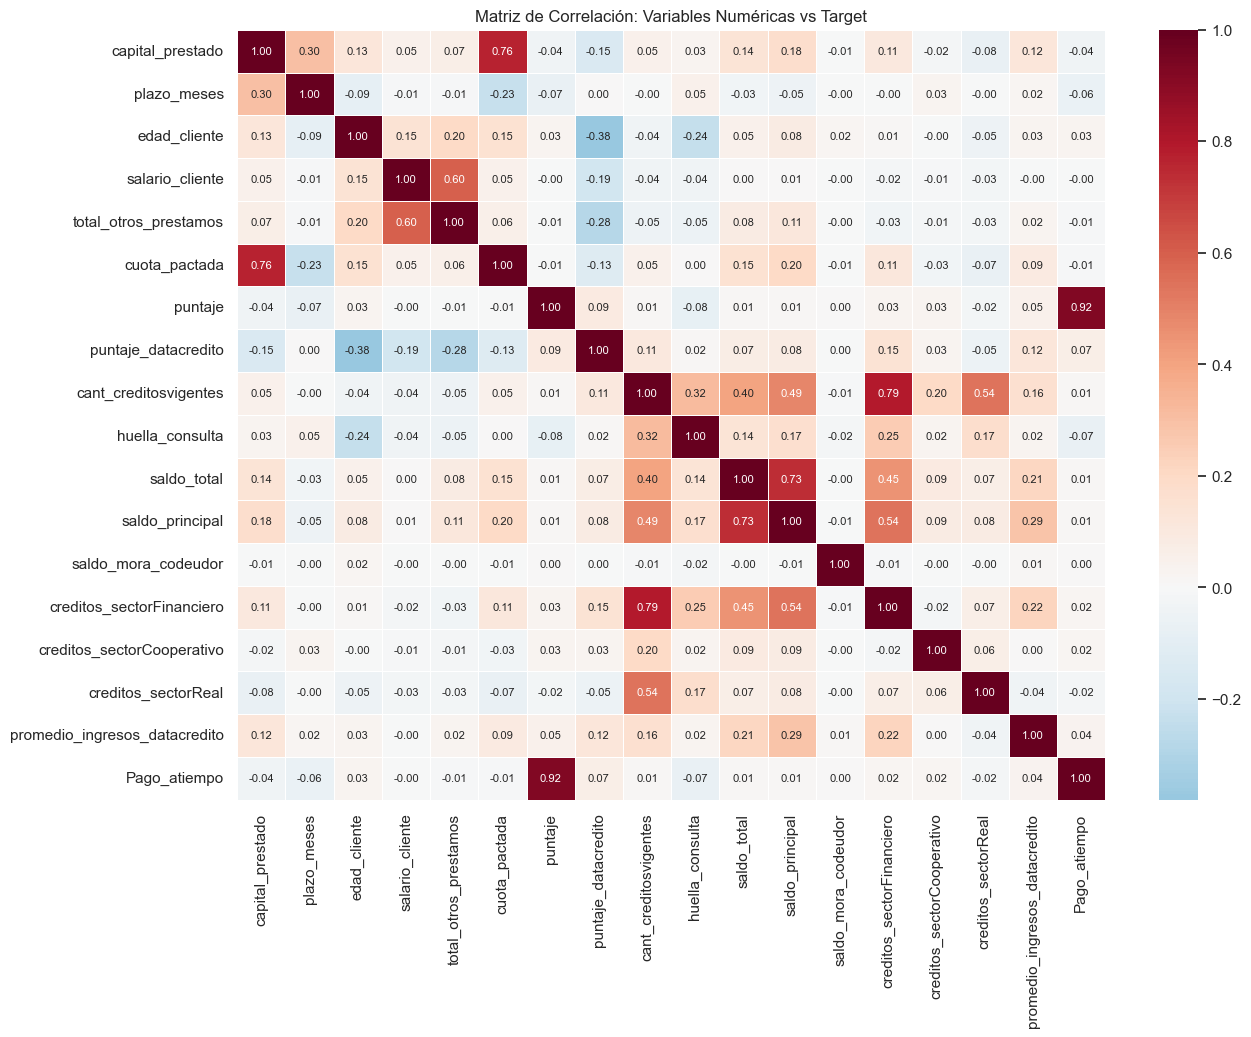


--- CORRELACIÓN DE VARIABLES CON EL PAGO A TIEMPO ---
Pago_atiempo                     1.000000
puntaje                          0.923134
huella_consulta                  0.073737
puntaje_datacredito              0.067882
plazo_meses                      0.063105
capital_prestado                 0.040624
promedio_ingresos_datacredito    0.039867
edad_cliente                     0.032252
creditos_sectorReal              0.023306
creditos_sectorFinanciero        0.021390
creditos_sectorCooperativo       0.021267
saldo_total                      0.014364
cuota_pactada                    0.011814
saldo_principal                  0.011473
total_otros_prestamos            0.010041
cant_creditosvigentes            0.008829
salario_cliente                  0.003981
saldo_mora_codeudor              0.002631
Name: Pago_atiempo, dtype: float64


In [966]:
# ==============================================================================
# 3. ANÁLISIS BIVARIABLE
# ==============================================================================

# 3.1 Matriz de Correlación (Heatmap)
# ------------------------------------------------------------------------------
plt.figure(figsize=(14, 10))

# Calculamos la correlación de Pearson para variables numéricas
# Nota: Incluimos el target convirtiéndolo a numérico temporalmente
corr_matrix = df[cols_num + [target]].copy()
corr_matrix[target] = corr_matrix[target].astype(int)
correlation = corr_matrix.corr()

# Generamos el Heatmap
sns.heatmap(
    correlation, 
    annot=True, 
    fmt=".2f", 
    cmap='RdBu_r', 
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)

plt.title('Matriz de Correlación: Variables Numéricas vs Target', fontsize=12)
plt.show()

# 3.2 Relación Específica con el Target (Top Correlaciones)
# ------------------------------------------------------------------------------
# Extraemos la correlación absoluta con el target para identificar los mejores predictores
top_corr = correlation[target].abs().sort_values(ascending=False)
print("\n--- CORRELACIÓN DE VARIABLES CON EL PAGO A TIEMPO ---")
print(top_corr)

1. Puntaje (0.92). Tiene una correlación positiva extremadamente alta (0.92). Esto significa que el puntaje interno que ya tiene el banco está casi perfectamente alineado con si el cliente paga o no.

Una correlación tan alta a veces puede indicar Data Leakage (fuga de datos). Si ese "puntaje" se calcula después de saber si el cliente pagó, no nos sirve para predecir el futuro. 

2. Correlaciones Débiles (Cercanas a 0)

Variables como salario_cliente (0.004) o cant_creditosvigentes (0.009) tienen una relación lineal casi inexistente con el pago en este momento. Esto no significa que no sirvan, sino que por sí solas no explican la mora. Probablemente necesiten combinarse con otras (análisis multivariado).

3. Multicolinealidad Detectada (Redundancia)

capital_prestado y cuota_pactada tienen una correlación de 0.76. Es lógico: a más préstamo, mayor cuota.

cant_creditosvigentes y creditos_sectorFinanciero tienen un 0.79. Básicamente miden lo mismo.

Para evitar que el modelo se confunda, más adelante podríamos elegir solo una de cada par.

La matriz revela que la mayoría de las variables tienen una correlación lineal débil con el pago a tiempo, lo que sugiere que el riesgo no depende de un solo factor, sino de una combinación compleja de ellos.Variables como huella_consulta y plazo_meses presentan correlaciones bajas pero significativas, sugiriendo que el riesgo es multivariado y no depende de una sola característica.

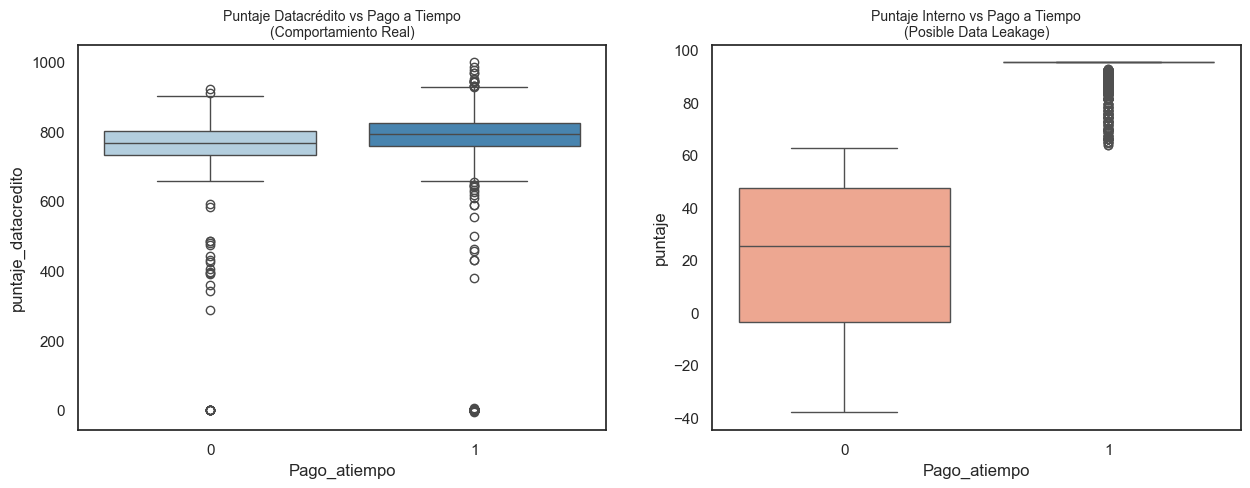

In [967]:
# ==========================================
# ANÁLISIS BIVARIABLE: COMPARACIÓN DE PREDICTORES
# ==========================================

# 3.3. Comparación de Boxplots (Predictor Real vs. Predictor Sospechoso)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Puntaje Datacrédito (Predictor Real - Externo)
sns.boxplot(x=target, y='puntaje_datacredito', data=df, palette='Blues', ax=axes[0])
axes[0].set_title('Puntaje Datacrédito vs Pago a Tiempo\n(Comportamiento Real)', fontsize=10)

# Puntaje (Predictor Sospechoso - Leakage)
sns.boxplot(x=target, y='puntaje', data=df, palette='Reds', ax=axes[1])
axes[1].set_title('Puntaje Interno vs Pago a Tiempo\n(Posible Data Leakage)', fontsize=10)

plt.show()

Puntaje Datacrédito (Predictor Real): Muestra un solapamiento saludable entre ambos grupos. Aunque los pagadores tienen puntajes más altos, la variable permite errores y matices, tal como ocurre en la realidad financiera.

Puntaje Interno (Leakage): La separación es perfecta y artificial. Los que no pagan tienen puntajes bajos y los que pagan tienen puntajes altos sin excepciones.

Conclusión: El puntaje interno conoce el futuro. Para que el simulador sea útil con clientes nuevos, esta variable debe ser eliminada, ya que de lo contrario el modelo no aprenderá a evaluar el perfil del cliente, sino solo a leer esta nota.

In [968]:
# 3.4 Análisis de Riesgo por Categorías (Negocio)
# ------------------------------------------------------------------------------
print("\n--- TASA DE DEFAULT POR PERFIL LABORAL ---")
# Calculamos el porcentaje de incumplimiento (0 = No paga)
tasa_mora_lab = df.groupby('tipo_laboral')[target].value_counts(normalize=True).unstack()
tasa_mora_lab['Tasa_Mora_%'] = (tasa_mora_lab[0] * 100).round(2)

# Mostramos solo el conteo y la tasa de mora para claridad
display(tasa_mora_lab[[0, 'Tasa_Mora_%']].rename(columns={0: 'Casos_Mora'}).sort_values(by='Tasa_Mora_%', ascending=False))


--- TASA DE DEFAULT POR PERFIL LABORAL ---


Pago_atiempo,Casos_Mora,Tasa_Mora_%
tipo_laboral,,
Independiente,0.055126,5.51
Empleado,0.042938,4.29


Independientes: Presentan la tasa de mora más alta con un 5.51%.

Empleados: Muestran un comportamiento más estable con una tasa de 4.29%.

Aunque el desbalanceo general es alto (pocos morosos en total), el riesgo relativo de un independiente es casi un 30% mayor que el de un empleado. El modelo deberá utilizar variables como el salario y el puntaje externo para mitigar este riesgo.

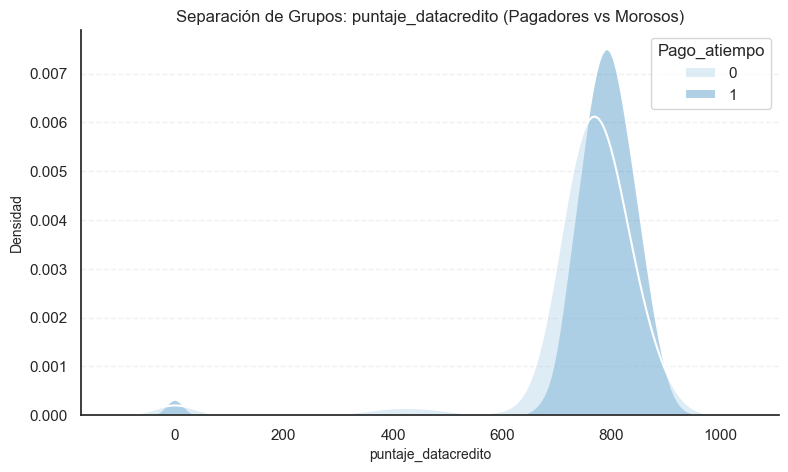

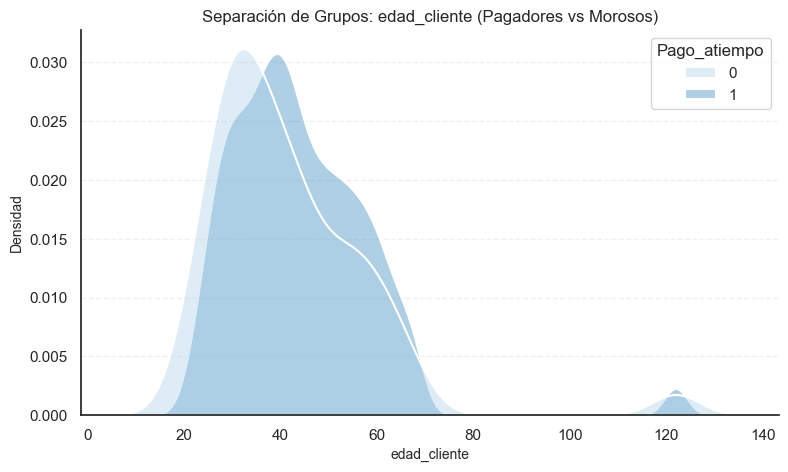

In [969]:
# ==============================================================================
# 3.5 ANÁLISIS DE DENSIDAD (OVERLAPPING) - ESTÉTICA CONSOLIDADA
# ==============================================================================
vars_overlap = ['puntaje_datacredito', 'edad_cliente']

for var in vars_overlap:
    plt.figure(figsize=(9, 5))
    
    # El parámetro 'common_norm=False' es vital para comparar las formas aunque un grupo sea más pequeño
    sns.kdeplot(data=df, x=var, hue=target, fill=True, common_norm=False, 
                palette='Blues', alpha=.4, linewidth=1.5, edgecolor=None # Elimina el borde grueso del relleno para evitar el efecto 3D 
                )
    
    plt.title(f'Separación de Grupos: {var} (Pagadores vs Morosos)', fontsize=12)
    plt.xlabel(var, fontsize=10)
    plt.ylabel('Densidad', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    sns.despine() # Limpia los bordes superior y derecho para un look más moderno
    plt.show()

En Puntaje Datacrédito: Observamos que la curva de los morosos (Target 0) es más "ancha" y está desplazada hacia la izquierda en comparación con la de los pagadores. Esto confirma que el score externo es un divisor de aguas: a medida que el puntaje baja, la densidad de morosos aumenta.

En Edad: Las curvas están muy solapadas, pero se nota un ligero incremento de la densidad de morosos en el rango de los 25 a 35 años. Esto sugiere que la edad no es un predictor tan fuerte como el puntaje por sí solo, pero aporta matices de riesgo en segmentos jóvenes.

Tras el análisis bivariable, se han identificado variables que, aunque parecen potentes, podrían perjudicar el desempeño del modelo o generar redundancia.

Variables a Eliminar:

- Puntaje (Interno): Se descarta por Data Leakage. Su correlación de 0.92 y la separación perfecta en los boxplots confirman que esta variable conoce el resultado del pago de antemano. No es útil para predecir clientes nuevos.

- Cuota_pactada: Se descarta por Multicolinealidad. Tiene una correlación de 0.76 con el capital_prestado. Dado que la cuota es un derivado matemático del monto y el plazo, mantenerla no aporta información nueva y confunde al algoritmo. (Si conocemos el capital, el plazo y la tasa de interés, la cuota es un resultado fijo. Al modelo le basta con tener el Capital (cuánto dinero arriesgamos) y el Plazo (cuánto tiempo estamos expuestos al riesgo) para entender la carga financiera.)

Variables con Correlación Alta que se Mantienen (Temporalmente)
Se han observado otras correlaciones significativas (ej. cant_creditosvigentes vs creditos_sectorFinanciero con 0.79). He decidido mantenerlas para el Análisis Multivariable por las siguientes razones:

Diferenciación de Perfil: Aunque están relacionadas, una mide "cantidad total" y la otra "calidad/fuente" del crédito.

Validación de Interacción: El análisis multivariable nos permitirá ver si juntas aportan más que por separado mediante gráficos de dispersión (Scatter Plots).

Tratamiento Posterior: Si en el modelado generan ruido, se aplicarán técnicas de reducción de dimensiones o creación de variables ratio (índices).

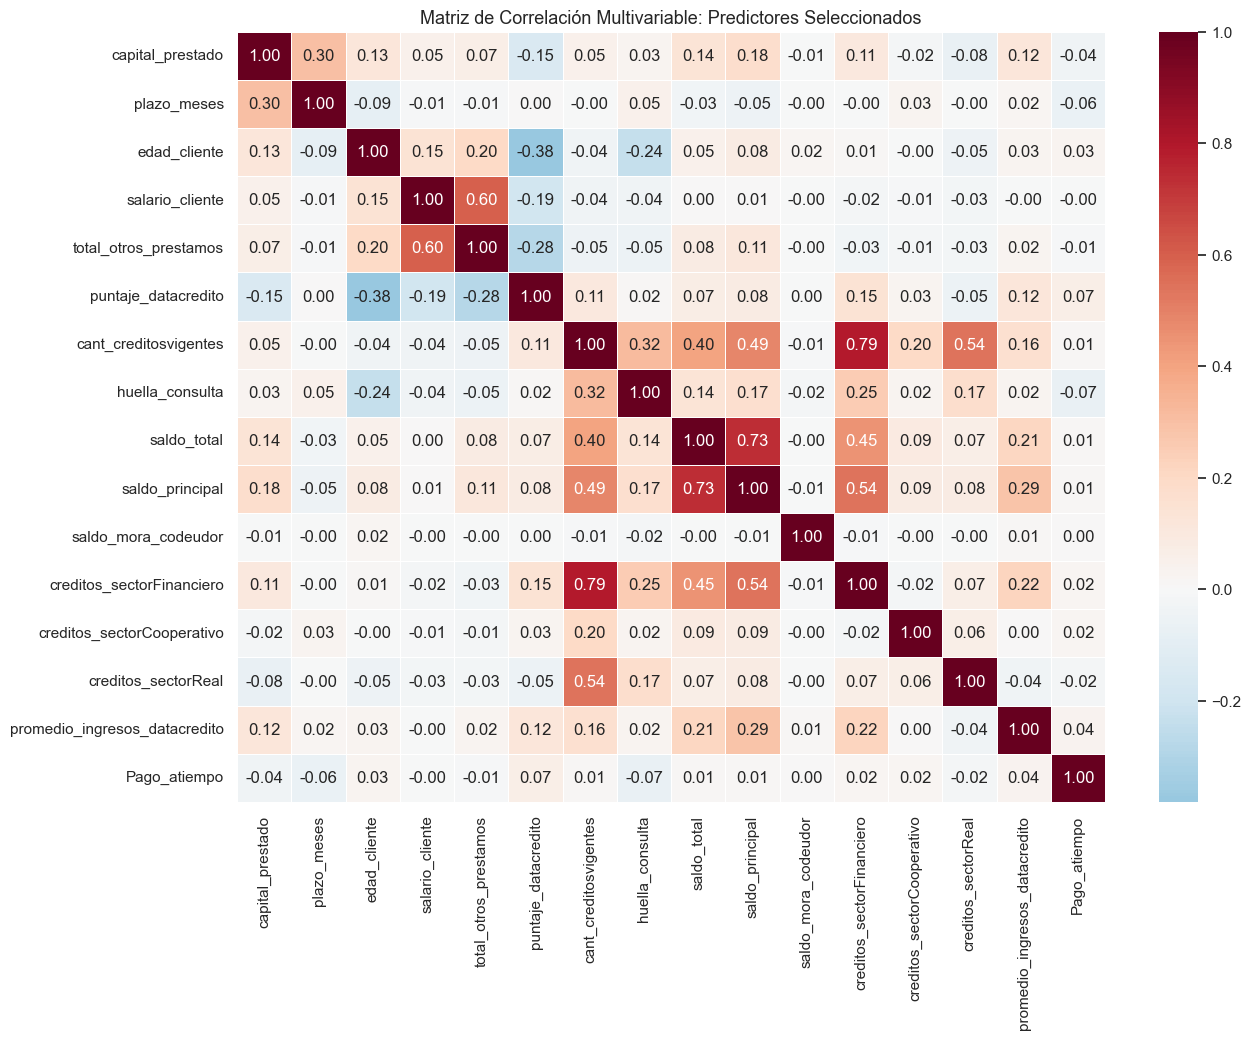


--- FUERZA DE LOS PREDICTORES FINALES (Relación con Pago_atiempo) ---
Pago_atiempo                     1.000000
huella_consulta                  0.073737
puntaje_datacredito              0.067882
plazo_meses                      0.063105
capital_prestado                 0.040624
promedio_ingresos_datacredito    0.039867
edad_cliente                     0.032252
creditos_sectorReal              0.023306
creditos_sectorFinanciero        0.021390
creditos_sectorCooperativo       0.021267
saldo_total                      0.014364
saldo_principal                  0.011473
total_otros_prestamos            0.010041
cant_creditosvigentes            0.008829
salario_cliente                  0.003981
saldo_mora_codeudor              0.002631
Name: Pago_atiempo, dtype: float64


In [970]:
# ==============================================================================
# 4. ANÁLISIS MULTIVARIABLE - PASO 1: LIMPIEZA Y DISPERSIÓN
# ==============================================================================

# 1. Limpieza física del dataset para el análisis multivariable
cols_drop = ['puntaje', 'cuota_pactada']
df_multiv = df.drop(columns=cols_drop)

# 2. Matriz de Correlación Final (Estética RdBu_r)
# Forzamos el target a entero para que aparezca en la matriz
df_multiv[target] = df_multiv[target].astype(int)

plt.figure(figsize=(14, 10))
sns.heatmap(df_multiv.corr(numeric_only=True), annot=True, fmt=".2f", 
            cmap='RdBu_r', center=0, linewidths=0.5)
plt.title('Matriz de Correlación Multivariable: Predictores Seleccionados', fontsize=13)
plt.show()

# 3. Mostrar la fuerza de los predictores respecto al Target
print("\n--- FUERZA DE LOS PREDICTORES FINALES (Relación con Pago_atiempo) ---")
print(corr_matrix_final[target].abs().sort_values(ascending=False))

Comportamiento Externo: La huella_consulta (0.073) y el puntaje_datacredito (0.067) lideran la capacidad predictiva. Esto indica que la actividad reciente de búsqueda de crédito y el historial previo son los mejores termómetros del riesgo.

Condiciones del Crédito: El plazo_meses (0.063) y el capital_prestado (0.040) superan en relevancia a variables demográficas como la edad, confirmando que la estructura del préstamo influye directamente en la probabilidad de impago.

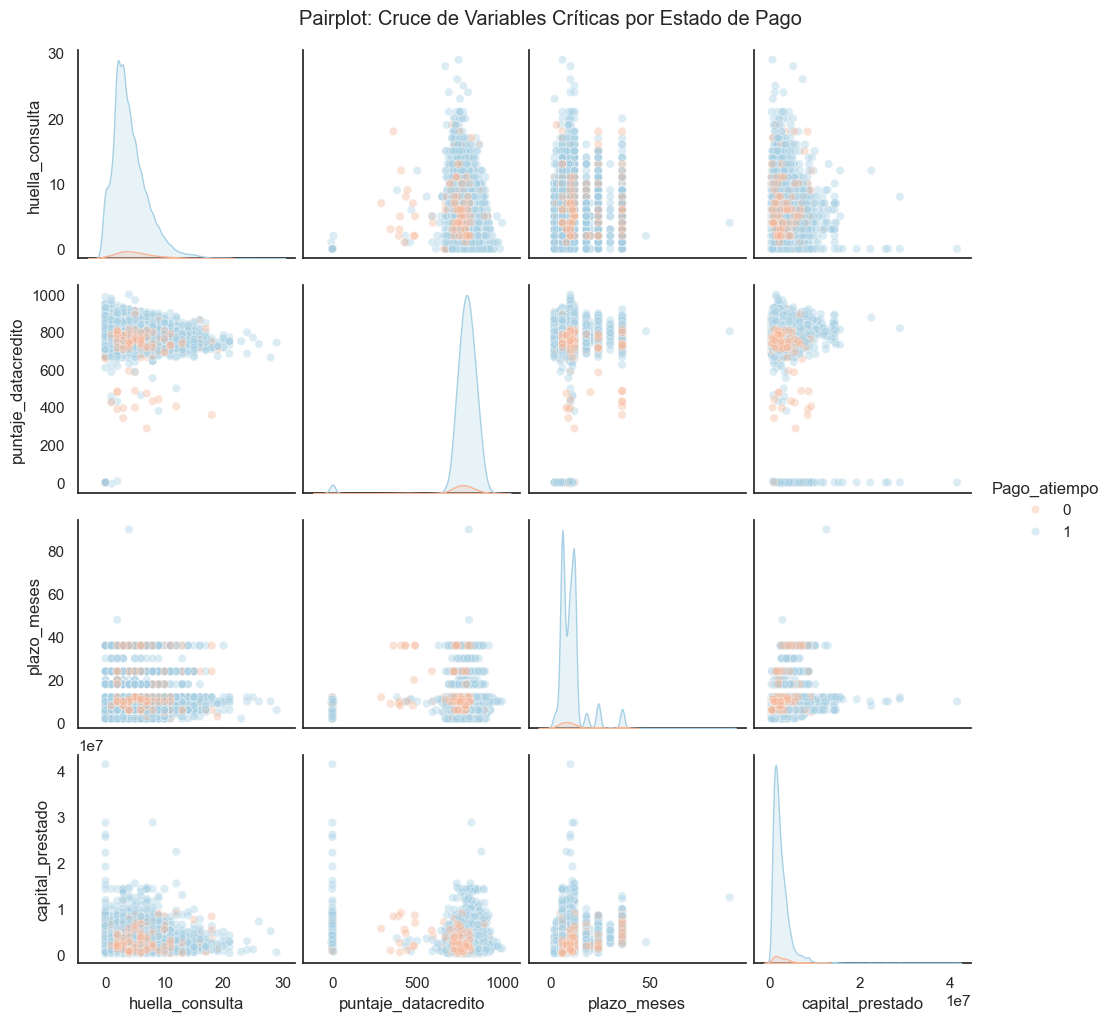

In [971]:
# 2. Pairplot: Interacción general de los mejores predictores
top_features = ['huella_consulta', 'puntaje_datacredito', 'plazo_meses', 'capital_prestado']

sns.pairplot(df_multiv, vars=top_features, hue=target, palette='RdBu', 
             plot_kws={'alpha': 0.4}, diag_kind='kde')
plt.suptitle('Pairplot: Cruce de Variables Críticas por Estado de Pago', y=1.02)
plt.show()

El cruce de las 4 variables más potentes revela la necesidad de transformaciones:

Capital Prestado: El gráfico muestra un sesgo positivo extremo (concentración en valores bajos con una cola muy larga hacia los 10 millones). Esto justifica una transformación logarítmica en la siguiente etapa para normalizar la escala.

Multicolinealidad Detectada: En la matriz de correlación se observa una relación fuerte entre cant_creditosvigentes y creditos_sectorFinanciero (0.79). Esto sugiere que para el modelo final se podría consolidar un índice de bancarización.

Edad y Plazo: No muestran una separación lineal clara por sí solas, lo que implica que el modelo de IA deberá capturar relaciones no lineales para extraer valor de estos atributos.

<Figure size 1000x700 with 0 Axes>

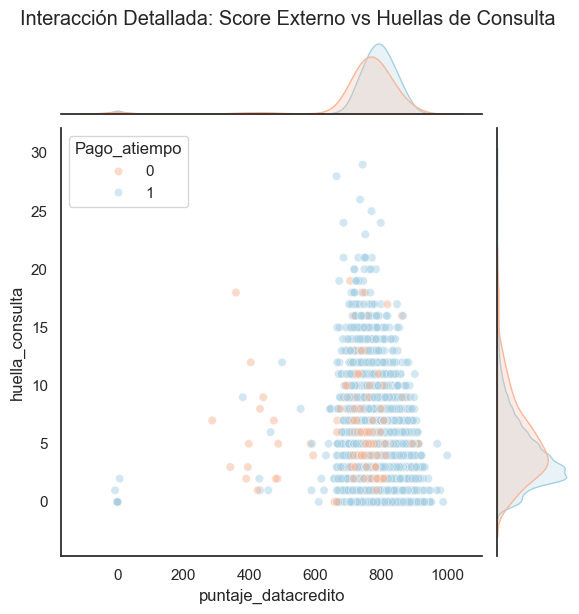

In [972]:
# 3. JointPlot: Zoom en la interacción Score Externo vs Huellas
plt.figure(figsize=(10, 7))
g = sns.jointplot(data=df_multiv, x='puntaje_datacredito', y='huella_consulta', 
                  hue=target, palette='RdBu', alpha=0.5, 
                  marginal_kws={'common_norm': False})
g.fig.suptitle('Interacción Detallada: Score Externo vs Huellas de Consulta', y=1.02)
plt.show()

En el Jointplot, la interacción entre estas dos variables críticas muestra patrones claros:

Zonas de Seguridad: Los clientes con puntaje_datacredito > 750 presentan una altísima tasa de éxito en el pago, incluso con niveles medios de consultas.

Zonas de Alerta: Se identifica un grupo de riesgo en puntajes bajos (< 500) donde la densidad de morosos (naranja) aumenta. La distribución marginal muestra que los morosos tienden a tener distribuciones de consultas más erráticas.

A partir de la inspección visual de los gráficos, se establecen las siguientes reglas para la etapa de pre-procesamiento:

Tratamiento de Outliers: Se deben filtrar registros con edad_cliente > 90 años identificados en el pairplot.

Capping de Consultas: Limitar el techo de huella_consulta a 20 para evitar que valores extremos distorsionen el entrenamiento.

Imputación Estratégica: Dado que promedio_ingresos_datacredito tiene un alto volumen de nulos, se validará su correlación con el salario reportado para decidir una técnica de llenado robusta.

In [973]:
# ==============================================================================
# PRE-PROCESAMIENTO: APLICACIÓN DE REGLAS DE VALIDACIÓN
# ==============================================================================

# 1. Filtro de Edad (Basado en la regla de validación)
df_clean = df_multiv[(df_multiv['edad_cliente'] >= 18) & (df_multiv['edad_cliente'] <= 90)].copy()

# 2. Capping de Huellas (Basado en la regla de validación)
df_clean['huella_consulta'] = df_clean['huella_consulta'].clip(upper=20)

# 3. Creación de Atributo Derivado (Basado en la propuesta)
# Ratio de Endeudamiento: Qué tanto del salario representa el capital solicitado
df_clean['ratio_endeudamiento'] = df_clean['capital_prestado'] / (df_clean['salario_cliente'] + 1)

# 4. Verificación de Nulos Críticos
print("--- Estado de Nulos antes de la Imputación ---")
print(df_clean[['promedio_ingresos_datacredito', 'saldo_total', 'puntaje_datacredito']].isnull().sum())

print(f"\nRegistros restantes tras filtros: {len(df_clean)}")

--- Estado de Nulos antes de la Imputación ---
promedio_ingresos_datacredito    2780
saldo_total                         7
puntaje_datacredito                 3
dtype: int64

Registros restantes tras filtros: 10613


In [974]:
# ==============================================================================
# IMPUTACIÓN DE VALORES FALTANTES
# ==============================================================================

# 1. Imputamos 'promedio_ingresos_datacredito' con la mediana
mediana_ingresos = df_clean['promedio_ingresos_datacredito'].median()
df_clean['promedio_ingresos_datacredito'] = df_clean['promedio_ingresos_datacredito'].fillna(mediana_ingresos)

# 2. Imputamos los nulos menores (saldo_total y puntaje_datacredito) con sus medianas
df_clean['saldo_total'] = df_clean['saldo_total'].fillna(df_clean['saldo_total'].median())
df_clean['puntaje_datacredito'] = df_clean['puntaje_datacredito'].fillna(df_clean['puntaje_datacredito'].median())

# 3. También tenemos nulos en 'saldo_principal' y 'saldo_mora_codeudor' (según df.info() previo)
# Los llenamos con 0, asumiendo que si es nulo es porque no tiene deuda activa o mora
df_clean['saldo_principal'] = df_clean['saldo_principal'].fillna(0)
df_clean['saldo_mora_codeudor'] = df_clean['saldo_mora_codeudor'].fillna(0)

# Verificación final de limpieza
print("--- Verificación Final de Nulos ---")
print(df_clean.isnull().sum().sum())
print(f"Tamaño final del dataset: {df_clean.shape}")

--- Verificación Final de Nulos ---
0
Tamaño final del dataset: (10613, 20)


Codificación Categórica (One-Hot Encoding)
Utilizaremos pd.get_dummies. Esta técnica crea una columna nueva para cada categoría. Si un cliente es "Empleado", tendrá un 1 en esa columna y un 0 en las demás. Esto evita que el modelo asuma órdenes de importancia inexistentes.

In [975]:
# ==============================================================================
# CODIFICACIÓN DE CATEGORÍAS (ONE-HOT ENCODING)
# ==============================================================================

# Seleccionamos las columnas de texto/categoría que quedaron tras la limpieza
cols_categoricas = ['tipo_credito', 'tipo_laboral']

# Aplicamos la transformación
# drop_first=True evita la "trampa de la variable ficticia" (redundancia matemática)
df_final_ia = pd.get_dummies(df_clean, columns=cols_categoricas, drop_first=True)

# Convertimos los valores True/False resultantes a 1/0
df_final_ia = df_final_ia.replace({True: 1, False: 0})

# Eliminamos la columna de fecha ya que no la usaremos para el entrenamiento
if 'fecha_prestamo' in df_final_ia.columns:
    df_final_ia = df_final_ia.drop(columns=['fecha_prestamo'])

print("--- Estructura Final del Dataset para el Modelo ---")
print(f"Número de filas: {df_final_ia.shape[0]}")
print(f"Número de columnas (atributos): {df_final_ia.shape[1]}")
print("\nColumnas finales:")
print(df_final_ia.columns.tolist())

--- Estructura Final del Dataset para el Modelo ---
Número de filas: 10613
Número de columnas (atributos): 23

Columnas finales:
['capital_prestado', 'plazo_meses', 'edad_cliente', 'salario_cliente', 'total_otros_prestamos', 'puntaje_datacredito', 'cant_creditosvigentes', 'huella_consulta', 'saldo_total', 'saldo_principal', 'saldo_mora_codeudor', 'creditos_sectorFinanciero', 'creditos_sectorCooperativo', 'creditos_sectorReal', 'promedio_ingresos_datacredito', 'Pago_atiempo', 'ratio_endeudamiento', 'tipo_credito_6', 'tipo_credito_7', 'tipo_credito_9', 'tipo_credito_10', 'tipo_credito_68', 'tipo_laboral_Independiente']


In [976]:
# Exportar el dataset procesado a la raíz
df_final_ia.to_csv('../Base_de_datos_procesada.csv', index=False)
print("Archivo exportado correctamente en la raíz del proyecto.")

Archivo exportado correctamente en la raíz del proyecto.
